In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt

#### Import World Bank data

In [2]:
def process_world_bank(dataset, subset):
    data = pd.read_csv(dataset, skiprows=2, parse_dates=True, header=1)
    data = data.drop(columns='Unnamed: 65')
    nums = data.loc[:, '1960':]
    nums = nums.fillna(method='ffill', axis=1)
    data.loc[:, '1960':] = nums
    data = data[['Country Name', 'Country Code', data.columns[-1]]]
    data.columns = ['Country Name','Country Code', subset]
    return data

In [3]:
gdp = process_world_bank('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_2445354.csv', 'GDPpc')

In [4]:
population = process_world_bank('API_SP.POP.TOTL_DS2_en_csv_v2_2445260.csv', 'Population')

In [5]:
#### Add continent data

In [6]:
continent = pd.read_csv('Metadata_Country_API_NY.GDP.PCAP.CD_DS2_en_csv_v2_2445354.csv')

In [7]:
continent = continent[['Country Code', 'Region', 'IncomeGroup']]

In [8]:
population = pd.merge(continent, population, left_on='Country Code', right_on='Country Code')

Merge the population and GDP datasets

In [9]:
pop_gdp = pd.merge(gdp, population, left_on='Country Name', right_on='Country Name')

In [10]:
pop_gdp = pop_gdp.drop(columns=['Country Code_y', 'Country Code_x'])

### Import vaccination data

In [11]:
data_vac = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')

In [12]:
# Fill latest NaN values 
new_vac = data_vac.fillna(method='ffill')

In [13]:
def getData(dataset):
    countries = []
    for country in dataset['location'].unique():
        dataInner = dataset[dataset.location == country]
        last_vac = dataInner.iloc[-1, :]
        countries.append(last_vac)
    return countries

In [14]:
parsedData = getData(new_vac)

In [15]:
parsedDf = pd.DataFrame(parsedData)

#### Subset the dataframes based on the intersection

In [16]:
country_intersect = np.intersect1d(pop_gdp['Country Name'].unique(), parsedDf['location'].unique())

In [17]:
vac_subset = parsedDf[parsedDf.location.isin(country_intersect)]

In [18]:
pop_gdp_subset = pop_gdp[pop_gdp['Country Name'].isin(country_intersect)]

#### Merge the two datasets

In [19]:
 merged = pd.merge(pop_gdp_subset, vac_subset, left_on='Country Name', right_on='location')

In [20]:
merged

,Country Name,GDPpc,Region,IncomeGroup,Population,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
0,Aruba,29007.693003,Latin America & Caribbean,High income,106314.0,Aruba,ABW,2021-06-21,124003.0,66894.0,57109.0,113.0,304.0,116.14,62.65,53.49,2847.0
1,Afghanistan,507.103432,South Asia,Low income,38041754.0,Afghanistan,AFG,2021-06-14,662003.0,484737.0,177266.0,4015.0,3272.0,1.70,1.25,0.46,84.0
2,Angola,2790.726615,Sub-Saharan Africa,Lower middle income,31825295.0,Angola,AGO,2021-06-20,1380174.0,866381.0,513793.0,1973.0,14642.0,4.20,2.64,1.56,446.0
3,Albania,5353.244856,Europe & Central Asia,Upper middle income,2854191.0,Albania,ALB,2021-06-21,890052.0,519674.0,370378.0,9140.0,6788.0,30.93,18.06,12.87,2359.0
4,Andorra,40886.391165,Europe & Central Asia,High income,77142.0,Andorra,AND,2021-06-14,51107.0,34646.0,16416.0,1973.0,1376.0,66.15,44.84,21.25,17809.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Samoa,4324.014018,East Asia & Pacific,Upper middle income,197097.0,Samoa,WSM,2021-06-21,45178.0,43983.0,1195.0,524.0,745.0,22.77,22.17,0.60,3755.0
179,Kosovo,4430.784947,Europe & Central Asia,Upper middle income,1788878.0,Kosovo,OWID_KOS,2021-06-20,133868.0,116057.0,17811.0,1800.0,5084.0,6.93,6.00,0.92,2630.0
180,South Africa,6001.401121,Sub-Saharan Africa,Upper middle income,58558267.0,South Africa,ZAF,2021-06-19,2141624.0,2141624.0,479768.0,4553.0,52601.0,3.61,3.61,0.81,887.0
181,Zambia,1305.063254,Sub-Saharan Africa,Lower middle income,17861030.0,Zambia,ZMB,2021-06-15,148304.0,142089.0,6215.0,388.0,91.0,0.81,0.77,0.03,5.0


In [21]:
merged['IncomeGroup'] = merged.IncomeGroup.map({"High income": "High", "Low income": "Low", "Lower middle income": "Lower middle", "Upper middle income": "Upper middle"})

In [22]:
merged['IncomeGroup']

0              High
1               Low
2      Lower middle
3      Upper middle
4              High
           ...     
178    Upper middle
179    Upper middle
180    Upper middle
181    Lower middle
182    Lower middle
Name: IncomeGroup, Length: 183, dtype: object

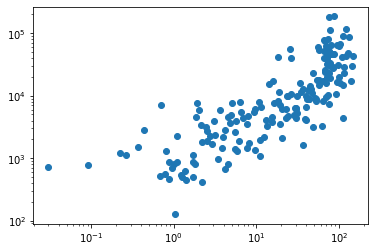

In [23]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(merged['total_vaccinations_per_hundred'], merged['GDPpc'])
ax.set_yscale('log')
ax.set_xscale('log')

In [24]:
merged = merged.drop(columns=['Country Name', 'date'])

In [25]:
merged.to_csv('chart.csv')

0      29007.693003
1        507.103432
2       2790.726615
3       5353.244856
4      40886.391165
           ...     
178     4324.014018
179     4430.784947
180     6001.401121
181     1305.063254
182     1463.985910
Name: GDPpc, Length: 183, dtype: float64